In [7]:
pip install opencv-python

     |################################| 28.3MB 10.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2

from UtilityTest import DepthDataset
from UtilityTest import ToTensor

In [5]:
from zipfile import ZipFile
zf = ZipFile('/workspace/test_img.zip', 'r')
zf.extractall('/workspace/')
zf.close()

In [2]:
loc_img="/workspace/test_img"

In [3]:
class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(loc_img))

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,os.listdir(loc_img)[idx])
        image = (Image.open(img_name))

        sample1={'image': image}

        if self.transform:  sample1 = self.transform({'image': image})
        return sample1

NameError: name 'Dataset' is not defined

0 (3840, 2160)
1 (3840, 2160)
2 (2160, 2136)
3 (3840, 2160)
4 (4032, 3024)
5 (4032, 3024)
6 (4032, 3024)


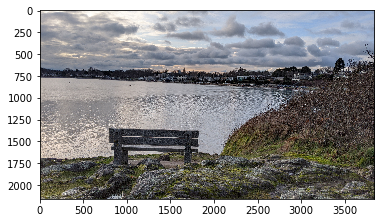

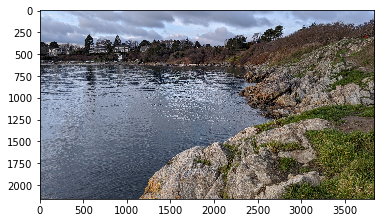

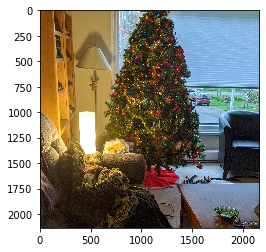

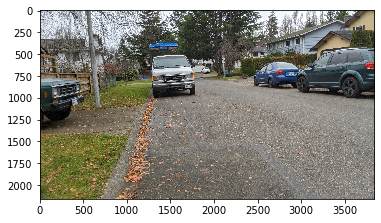

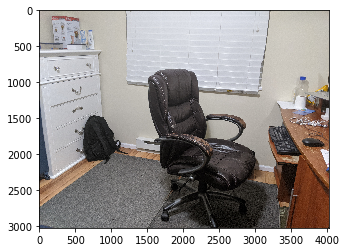

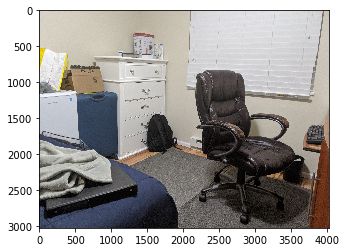

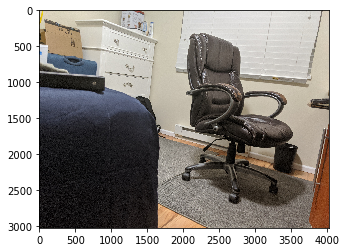

<Figure size 432x288 with 0 Axes>

In [3]:
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print(i, sample['image'].size)
    plt.imshow(sample['image'])
    plt.figure()

    if i == 6:
        plt.show()
        break

In [27]:
# def _is_pil_image(img):
#     return isinstance(img, Image.Image)

# def _is_numpy_image(img):
#     return isinstance(img, np.ndarray) and (img.ndim in {2, 3})
# class ToTensor(object):
#     def __init__(self,is_test=False):
#         self.is_test = is_test

#     def __call__(self, sample):
#         image= sample['image']
        
#         image = image.resize((640, 480))
#         image = self.to_tensor(image)

#         return {'image': image}

#     def to_tensor(self, pic):
#         pic = np.array(pic)
#         if not (_is_numpy_image(pic) or _is_pil_image(pic)):
#                 raise TypeError(  'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
                
# #         if not(_is_pil_image(pic)): 
# #             raise TypeError(
# #                 'pic should be PIL Image . Got {}'.format(type(pic)))        
               
#         if isinstance(pic, np.ndarray):
#             if pic.ndim==2:
#                 pic=pic[..., np.newaxis]
                
#             img = torch.from_numpy(pic.transpose((2, 0, 1)))

#             return img.float().div(255)


In [4]:
depth_dataset = DepthDataset(root_dir=loc_img,
                transform=transforms.Compose([ToTensor()]))
depth_dataset

In [5]:
batch_size=1
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
train_loader

In [6]:
dataiter = iter(train_loader)
images = dataiter.next()



In [7]:
#importing the model 
from model_dense import Model

In [9]:
model = Model().cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/workspace/1.pth'))
model.eval()


DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): DenseNet(
        (features): Sequential(
          (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu0): ReLU(inplace=True)
          (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (denseblock1): _DenseBlock(
            (denselayer1): _DenseLayer(
              (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): ReLU(inplace=True)
              (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu2): ReLU(inplace=True)
              (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [10]:
#Upscaling image and saving the image
for i,sample_batched1  in enumerate (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    x=outtt.detach().cpu().numpy()
    x.shape
    x=x.reshape(120,160)

    img=x
    scale_percent = 120 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    plt.imsave('/workspace/test_img/geeks%d.jpg' %i, resized, cmap='inferno')  

In [18]:
import zipfile

zf = zipfile.ZipFile("myzipfile.zip", "w")
for dirname, subdirs, files in os.walk("/workspace/test_img/"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()